## Abstract

- Télécharger les cours de bourses
- Produire lunr nouvelle dataframe faisant étant des MAE pour chaque prévision de cours 

## Bibliothèques

In [1]:
# Générique data project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

# Pour la manipulation de fichiers
import os
import glob
from pathlib import Path

# Pour RNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dense, RNN,GRUCell,InputLayer,Embedding,Dropout


# MISC
import warnings
warnings.filterwarnings("ignore")
import swifter
import random

## Set up

In [2]:
df = pd.read_csv('sp500_stocks.csv')
df = df.dropna()
df

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
1,2010-01-04,MMM,59.318886,83.019997,83.449997,82.669998,83.089996,3043700.0
2,2010-01-05,MMM,58.947342,82.500000,83.230003,81.699997,82.800003,2847000.0
3,2010-01-06,MMM,59.783295,83.669998,84.599998,83.510002,83.879997,5268500.0
4,2010-01-07,MMM,59.826176,83.730003,83.760002,82.120003,83.320000,4470100.0
5,2010-01-08,MMM,60.247749,84.320000,84.320000,83.300003,83.690002,3405800.0
...,...,...,...,...,...,...,...,...
1561387,2022-04-07,ZTS,197.929993,197.929993,199.339996,190.970001,191.199997,2781400.0
1561388,2022-04-08,ZTS,200.089996,200.089996,201.320007,197.589996,197.789993,2455500.0
1561389,2022-04-11,ZTS,192.500000,192.500000,199.880005,192.009995,198.970001,2252200.0
1561390,2022-04-12,ZTS,187.910004,187.910004,193.309998,187.149994,192.110001,1746500.0


On affiche les 10 premières société présentant le plus d'entrées

In [3]:
dictus = {}

for comp in df.Symbol.unique():
    TEMP = df[df['Symbol']==comp]
    dictus[comp]=len(TEMP)
    
visu = pd.DataFrame.from_dict(dictus,orient ='index').rename(columns={0:'Longueur'}).sort_values(by=['Longueur'],ascending=False) 

In [4]:
visu.head(10)

,Longueur
MMM,3092
MPWR,3092
NEE,3092
NEM,3092
NWL,3092
NFLX,3092
NTAP,3092
NDAQ,3092
MSCI,3092
MSI,3092


In [5]:
DF = df[df['Symbol']=='DXC']

## Paramètres

In [6]:
sequence_len = 20
predict_len  = 5
train_prop    = 0.8
batch_size    = 32
epok        = 20
cwd = os.getcwd()
path = cwd

## Préparation 

On choisi la variable à étudier

In [7]:
dataset = np.array(DF.Close)

In [8]:
dataset

array([28.6860199 , 28.67608261, 28.78041458, ..., 30.87999916,
       30.70000076, 31.01000023])

On scinde l'ensemble en jeu de données et jeu d'entrainement

In [9]:
k = int(len(dataset)*train_prop)
x_train = dataset[:k]
x_test  = dataset[k:]

On procède à une normalisation

In [10]:
mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

print("Dataset generated.")
print("Train shape is : ", x_train.shape)
print("Test  shape is : ", x_test.shape)

x_train = x_train.reshape(-1,1)
x_test = x_test.reshape(-1,1)
print("Train shape is : ", x_train.shape)
print("Test  shape is : ", x_test.shape)

Dataset generated.
Train shape is :  (2473,)
Test  shape is :  (619,)
Train shape is :  (2473, 1)
Test  shape is :  (619, 1)


## Génération de données

In [11]:
train_generator = TimeseriesGenerator(x_train,x_train ,length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(x_test,x_test , length=sequence_len,  batch_size=batch_size)

In [12]:
x,y=train_generator[70]
print(f'Number of batch trains available : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

Number of batch trains available :  77
batch x shape :  (32, 20, 1)
batch y shape :  (32, 1)


## Création du model

In [13]:
model = keras.models.Sequential()


model.add(keras.layers.GRU(64, return_sequences=False,input_shape=(sequence_len,1),activation='relu') )
model.add(Dropout(0.3))

model.add(keras.layers.Dense(1))

model.compile(optimizer='rmsprop', 
              loss='mse', 
              metrics   = ['mae'] )

bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path, verbose=0, save_best_only=True)

training_history=model.fit(train_generator,
                  epochs  = epok, 
                  validation_data = test_generator,
                          callbacks = [bestmodel_callback])

Epoch 1/20
77/77 [==============================] - 3s 11ms/step - loss: 0.5023 - mae: 0.4687 - val_loss: 0.0063 - val_mae: 0.0575
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
Epoch 2/20
77/77 [==============================] - 1s 8ms/step - loss: 0.0562 - mae: 0.1599 - val_loss: 0.0046 - val_mae: 0.0487
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
Epoch 3/20
77/77 [==============================] - 1s 7ms/step - loss: 0.0382 - mae: 0.1368 - val_loss: 0.0059 - val_mae: 0.0552
Epoch 4/20
77/77 [==============================] - 1s 7ms/step - loss: 0.0386 - mae: 0.1333 - val_loss: 0.0044 - val_mae: 0.0469
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
Epoch 5/20
77/77 [==============================] - 1s 7ms/step - loss: 0.0364 - mae: 0.1275 - val_loss: 0.0037 - val_mae: 0.0438
INFO:tensorflow:Assets written to: C:\Users\Utilisateur\assets
Epoch 6/20
77/77 [==============================] - 1s 7ms/step - loss: 0.0358 - mae: 0.1250 - va

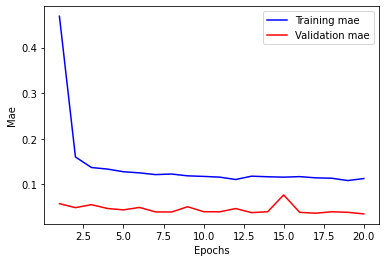

In [14]:
train_acc = training_history.history['mae']
val_acc = training_history.history['val_mae']

plt.xlabel('Epochs')
plt.ylabel('Mae')

plt.plot(np.arange(1,epok +1,1),training_history.history['mae'], label='Training mae', color='blue')
plt.plot(np.arange(1,epok +1,1),training_history.history['val_mae'], label='Validation mae', color='red')

plt.legend()

plt.show()

In [15]:
loaded_model =  tf.keras.models.load_model(cwd)

In [16]:
loss,mae =loaded_model.evaluate(test_generator)

19/19 [==============================] - 0s 3ms/step - loss: 0.0023 - mae: 0.0349


##  Prédire et visualiser

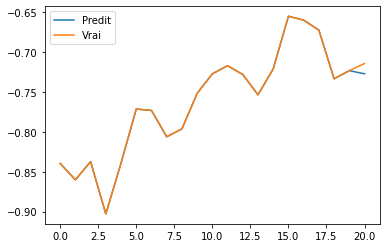

In [17]:
# On sélectionne une séquence au hasard du jeu de test
s=random.randint(0,len(x_test)-sequence_len)
sequence      = x_test[s:s+sequence_len]

# On définit la séquence réelle à observer
sequence_true = x_test[s:s+sequence_len+1]

# On prédit la valeur suivante de sequence
prediction = model.predict( np.array([sequence]))

# On affiche
plt.plot(np.concatenate([sequence,prediction]),label = 'Predit')
plt.plot(sequence_true,label = 'Vrai')

plt.legend()
plt.show()


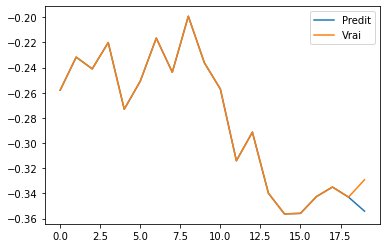

In [18]:
# On sélectionne la dernière séquence
sequence = x_test[-sequence_len:-1]

# On définit la séquence réelle à observer
sequence_true = x_test[-sequence_len:]

# On prédit la valeur suivante de sequence
prediction = model.predict( np.array([sequence]))

# On affiche
plt.plot(np.concatenate([sequence,prediction]),label = 'Predit')
plt.plot(sequence_true,label = 'Vrai')

plt.legend()
plt.show()

In [20]:
Predicat =[]
step = 4
iteration = list(reversed([i for i in range(step)]))

for i in iteration:
    sequence = x_test[-sequence_len-i:-i-1]
   
    prediction = model.predict( np.array([sequence]))
    Predicat.append(prediction)

In [21]:
vue = np.concatenate([Predicat[0],Predicat[1],Predicat[2],Predicat[3]])

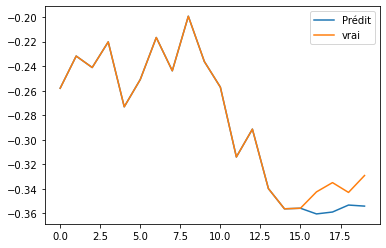

In [22]:
plt.plot(np.concatenate([x_test[-sequence_len:-step],vue]),label = 'Prédit')
plt.plot(x_test[-sequence_len:],label = 'vrai')

plt.legend()

plt.show()

## Généraliser

On applique la démarche pour chaque cours et on stocke les valeurs dans une dataframe

In [ ]:
fit_verbosity = 0
scores = {}

def evalue(x):


    DF = df[df['Symbol']==x]
    dataset = np.array(DF.Close)
    k = int(len(dataset)*train_prop)
    x_train = dataset[:k]
    x_test  = dataset[k:]
    mean = x_train.mean()
    std  = x_train.std()
    x_train = (x_train - mean) / std
    x_test  = (x_test  - mean) / std
    x_train = x_train.reshape(-1,1)
    x_test = x_test.reshape(-1,1)
    train_generator = TimeseriesGenerator(x_train,x_train ,length=sequence_len,  batch_size=batch_size)
    test_generator  = TimeseriesGenerator(x_test,x_test , length=sequence_len,  batch_size=batch_size)
    
    model = keras.models.Sequential()
    
    model.add(keras.layers.GRU(64, return_sequences=False,input_shape=(sequence_len,1),activation='relu') )
    model.add(Dropout(0.3))
    

    
    model.add(keras.layers.Dense(1))
    model.compile(optimizer='rmsprop', 
              loss='mse', 
              metrics   = ['mae'] )
    bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path, verbose=0, save_best_only=True)

    training_history=model.fit(train_generator,
                  epochs  = epok, 
                  validation_data = test_generator,
                          callbacks = [bestmodel_callback])
    
    loaded_model =  tf.keras.models.load_model(cwd)




    loss,mae =loaded_model.evaluate(test_generator)
    return mae


In [ ]:
visu = visu.reset_index().rename(columns={'index':'titre'})
extrait = visu[visu['Longueur']==3092]

In [ ]:
MMM = evalue('MMM')

In [ ]:
MMM

In [ ]:
extrait

In [ ]:
extrait['score']=extrait.titre.swifter.apply(lambda x: evalue(x))

In [ ]:
np.save('extrait_RNN',extrait)